In [65]:
%pip install tensorflow seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Note: you may need to restart the kernel to use updated packages.


load dataset

In [66]:
# Load Pima Indian Diabetes dataset
df = pd.read_csv("F:/RUSL/4- 1/ICT 4302 - Intelligent Systems/miniProject1/diabetes.csv")

df.columns = df.columns.str.strip()  # Clean header spaces
for col in df.columns:
    if col != 'Outcome':
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN

numeric_df = df.select_dtypes(include=['number'])

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data preprocessing

step 1 - Replace invalid zeros with NaN (handle missing values)

In [67]:
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with np.nan only for these features
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)


In [68]:
# Remove rows with too many missing values
def drop_rows_with_many_missing(df, threshold_cols=4):
    return df[df[cols_with_missing].isnull().sum(axis=1) < threshold_cols]

df = drop_rows_with_many_missing(df)

In [69]:
# Define columns for different strategies
median_columns = ["Glucose", "BloodPressure"]
knn_columns = ["SkinThickness", "Insulin", "BMI"]

step 2 - fill missing values using the median of the same class

In [70]:
# Apply same-class median imputation
def impute_same_class_median(df, columns, class_col="Outcome"):
    for col in columns:
        df[col] = df.groupby(class_col)[col].transform(lambda x: x.fillna(x.median()))
    return df

df = impute_same_class_median(df, median_columns)

In [71]:
# Apply KNN Imputer for selected columns
def knn_impute(df, columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[columns] = imputer.fit_transform(df[columns])
    return df

df = knn_impute(df, knn_columns)

In [72]:
# Normalize features (optional but recommended)
from sklearn.preprocessing import MinMaxScaler


features = df.columns[:-1]  # Exclude Outcome
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [73]:
print("✅ Cleaned dataset ready for model:")
display(df.head())

✅ Cleaned dataset ready for model:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.213221,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.128125,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.106522,0.106010,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1


In [74]:
# ----- AFTER preprocessing and missing value handling -----

# Balance the dataset
class_0 = df[df['Outcome'] == 0]
class_1 = df[df['Outcome'] == 1]

min_size = min(len(class_0), len(class_1))
class_0_sampled = class_0.sample(n=min_size, random_state=42)
class_1_sampled = class_1.sample(n=min_size, random_state=42)

balanced_df = pd.concat([class_0_sampled, class_1_sampled], axis=0)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [75]:
X = balanced_df.drop("Outcome", axis=1)
y = balanced_df["Outcome"]

data split

In [76]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


build custom keras model

In [77]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#add extra hidden layer and change number of nodes in each layer

In [78]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#add extra hidden layer and change number of nodes in each layer

In [79]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                576       
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 16)                1040      
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


Train the model

In [80]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=2) #change validation0split from 0.2-> 0.1


Epoch 1/100
24/24 - 6s - loss: 0.6924 - accuracy: 0.4844 - val_loss: 0.6736 - val_accuracy: 0.6047 - 6s/epoch - 243ms/step
Epoch 2/100
24/24 - 0s - loss: 0.6821 - accuracy: 0.5234 - val_loss: 0.6649 - val_accuracy: 0.6279 - 374ms/epoch - 16ms/step
Epoch 3/100
24/24 - 0s - loss: 0.6782 - accuracy: 0.5391 - val_loss: 0.6500 - val_accuracy: 0.7209 - 289ms/epoch - 12ms/step
Epoch 4/100
24/24 - 0s - loss: 0.6758 - accuracy: 0.5677 - val_loss: 0.6372 - val_accuracy: 0.8140 - 363ms/epoch - 15ms/step
Epoch 5/100
24/24 - 0s - loss: 0.6673 - accuracy: 0.6510 - val_loss: 0.6235 - val_accuracy: 0.8372 - 356ms/epoch - 15ms/step
Epoch 6/100
24/24 - 0s - loss: 0.6502 - accuracy: 0.6953 - val_loss: 0.6069 - val_accuracy: 0.8372 - 271ms/epoch - 11ms/step
Epoch 7/100
24/24 - 0s - loss: 0.6428 - accuracy: 0.7005 - val_loss: 0.5927 - val_accuracy: 0.8605 - 234ms/epoch - 10ms/step
Epoch 8/100
24/24 - 0s - loss: 0.6290 - accuracy: 0.6927 - val_loss: 0.5674 - val_accuracy: 0.8605 - 248ms/epoch - 10ms/step
Ep

Evaluate the model

4/4 [==============================] - 0s 4ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.64      0.69        56
           1       0.66      0.75      0.70        51

    accuracy                           0.69       107
   macro avg       0.69      0.69      0.69       107
weighted avg       0.70      0.69      0.69       107

4/4 [==============================] - 0s 4ms/step


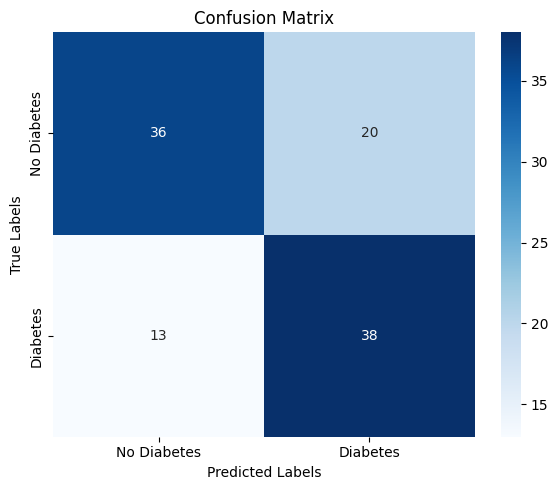

Accuracy: 0.6915887850467289
Precision: 0.6551724137931034
Recall: 0.7450980392156863
F1 Score: 0.6972477064220184


In [81]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# Predict probabilities
y_pred_prob = model.predict(X_test).ravel()

# Convert to binary output
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict probabilities and convert to binary
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['No Diabetes', 'Diabetes']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# Individual metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


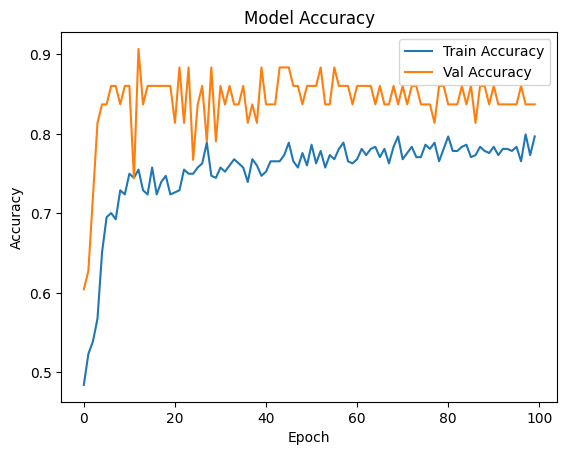

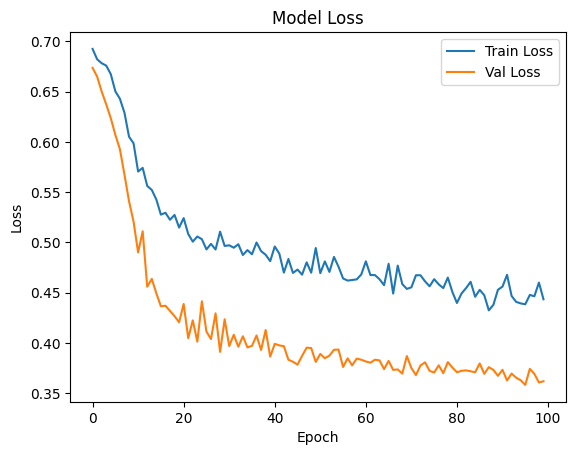

In [82]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
